## Ergotropy

The goal of this notebook is to compute the ergotropy $W$ of a system $S$, given an arbitrary initial state and hamiltonian $H$. The ergotropy $W$ is none other that the maximum amount of work extractable from a finite system, and it is given by

$$
W = E(\rho_0) - E(\rho(\tau)) = tr[\rho_0 H] - tr[\rho(\tau) H] = \sum_{j,k}r_j\epsilon_k(|\langle r_j|\epsilon_k \rangle|^2-\delta_{jk})
$$

where we wrote 

$$
\rho_0 = \sum_{j \geqslant 1}r_j|r_j\rangle \langle r_j| \\
H = \sum_{k \geqslant 1}\epsilon_k|\epsilon_k\rangle \langle \epsilon_k| \\
\rho(\tau) = \sum_{j}r_j|\epsilon_j\rangle \langle \epsilon_j|
$$ 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cmath
from IPython.display import Image
from qutip import (Qobj, about, basis, coherent, coherent_dm, create, destroy,
                   expect, variance, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, sigmam, sigmap, tensor, thermal_dm, lindblad_dissipator)

%matplotlib inline

In [2]:
def kronecker_delta(a,b):
    if a==b: return 1
    else: return 0

In [3]:
def ergotropy(_rho, _H):
    # for now I assume that init_state is given as a density matrix
    # TODO: add a check to enforce this!
    
    _energy = expect(_H, _rho)
    # Calculate eigenvalues, and save them in the wanted ordering
    _rho_eigenvalues = _rho.eigenenergies(sort='high')
    _H_eigenenergies = _H.eigenenergies(sort='low')    
    
    _energy_passive = 0.
    for i in range(len(_rho_eigenvalues)):
        _energy_passive += _rho_eigenvalues[i]*_H_eigenenergies[i]
    
    return _energy - _energy_passive

## Master equations solutions
In the following we compare our numerical solutions (obtained via `mesolve`) with the analytical solutions of the article. First we consider the state of the battery and of the charger as harmonic oscillators, and then as qubits. 
We are going to compare the plots of the mean energy $E_B(\tau)$ and of the ergotropy $\epsilon_B(\tau)$, defined as:

$$
E_B(\tau) \equiv tr[H_B \rho_B(\tau)] \\
\epsilon_B(\tau) \equiv tr[H_B \rho_B(\tau)] - \min_{U_B} tr[H_B U_B \rho_B(\tau) U_B\dagger ]
$$

In [115]:
# Define some constants
w_zero = 5.
g = 0.2 * w_zero
n_modes = 13 # the higher the better (the Hilbert space of two harmonic oscillators is infinite)

In [116]:
# hamiltonian of B
b_B = destroy(n_modes)
H_B = w_zero * b_B.dag() * b_B

In [6]:
# define the analytical results for Energy and Ergotropy
def E_B_theory_only_T(_w_zero, _gamma, _g, _N_B, _t):
    eps = cmath.sqrt(_gamma**2 - (4*_g)**2)
    return _w_zero*_N_B*( 1 + (np.exp(-0.5*_gamma*_t)/(eps**2))*(
        16*_g**2 - _gamma*eps*np.sinh(eps*_t*0.5) - _gamma**2 * np.cosh(eps*_t*0.5)) )

def E_B_theory_only_F(_w_zero, _gamma, _g, _F, _t):
    eps = cmath.sqrt(_gamma**2 - (4*_g)**2)
    return ( (w_zero*_F**2) / (_g**2) ) * (1 - np.exp(-_gamma*_t*0.25)*( 
        np.cosh(eps*_t*0.25) + (_gamma/eps) * np.sinh(eps*_t*0.25) ) )**2

def Ergotropy_B_theory(_w_zero, _rho):
    _D = (1 + 2*expect(b_B.dag()*b_B, _rho) - 2*abs(expect(b_B,_rho))**2)**2 - 4*abs(
        variance(b_B,_rho))**2
    return _w_zero*(expect(b_B.dag()*b_B, _rho) - (cmath.sqrt(_D)-1)/2)

In [117]:
# First case, two harmonic oscillators
a = tensor(destroy(n_modes), qeye(n_modes))
b = tensor(qeye(n_modes), destroy(n_modes))

#H_A = w_zero * a.dag() * a
#H_B = w_zero * b.dag() * b

def delta_HA_t0(_F):
    return _F * ( a.dag() + a)

def H_AB(_g):
    return _g * (a * b.dag() + a.dag() * b)

def D_A(_N_B, _gamma):
    return _gamma * (_N_B + 1) * lindblad_dissipator(a)

def D_AD(_N_B, _gamma):
    return _gamma * _N_B * lindblad_dissipator(a.dag())

# at t = 0, A and B do not interact, and they are respectvaly in their ground state
rho0 = tensor(fock_dm(n_modes,0), fock_dm(n_modes,0))

# times to resolve the m.e. at
gtlist = np.linspace(0, g*150, 250)

In [118]:
# Underdamped case
F = 0.1 * w_zero
N_B = 1.0 # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = 0.05 * w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F), rho0, gtlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_both = [ expect(H_B, rho_B[i]) / w_zero for i in range(len(rho_B))]
ergotropy_B_both = [ ergotropy(rho_B[i], H_B) / w_zero for i in range(len(rho_B)) ]
ergotropy_B_theory_both = [ Ergotropy_B_theory(w_zero, rho_B[i]) / w_zero for i in range(len(rho_B)) ]

In [119]:
F = 0
N_B = 1.0 # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = 0.05 * w_zero

# now, I use mesolve to solve the master equatio
result = mesolve(H_AB(g) + delta_HA_t0(F), rho0, gtlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_only_T = [ expect(H_B, rho_B[i]) / w_zero for i in range(len(rho_B))]
ergotropy_B_only_T = [ ergotropy(rho_B[i], H_B) / w_zero for i in range(len(rho_B)) ]

In [120]:
F = 0.1 * w_zero
N_B = 0. # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = 0.05 * w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F), rho0, gtlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_only_F = [ expect(H_B, rho_B[i]) / w_zero for i in range(len(rho_B))]
ergotropy_B_only_F = [ ergotropy(rho_B[i], H_B) / w_zero for i in range(len(rho_B)) ]

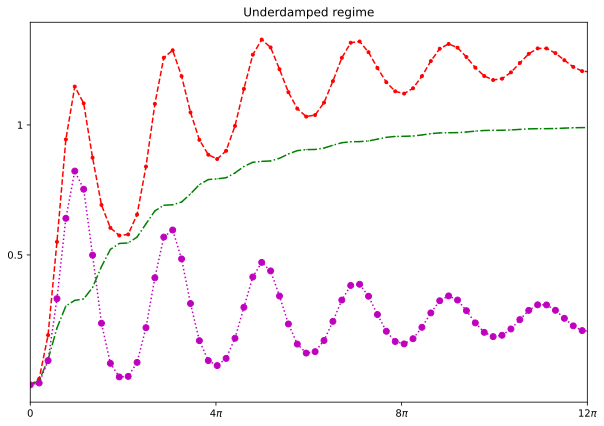

In [121]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, E_B_numeric_both, '.--r', gtlist, E_B_numeric_only_T, ',-.g', gtlist, E_B_numeric_only_F, 'o:m')
ax.set_xlim(0, 12*np.pi)
ax.set_xticks([0., 4*np.pi, 8*np.pi, 12*np.pi],
               labels=["$0$", r"$4\pi$", r"$8\pi$", r"$12\pi$"])
ax.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])
ax.set_title("Underdamped regime")
plt.show()

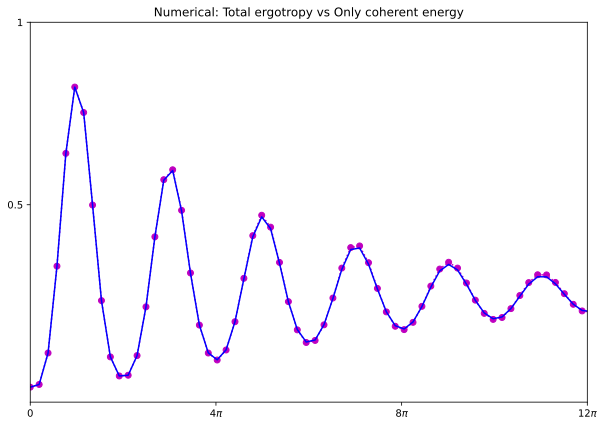

In [122]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, E_B_numeric_only_F, 'o:m', gtlist, ergotropy_B_both, '-b')
ax.set_xlim(0, 12*np.pi)
ax.set_xticks([0., 4*np.pi, 8*np.pi, 12*np.pi],
               labels=["$0$", r"$4\pi$", r"$8\pi$", r"$12\pi$"])
ax.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])
ax.set_title("Numerical: Total ergotropy vs Only coherent energy") #they should be superimposed!!
plt.show()

In [123]:
F = 0.1 * w_zero
N_B = 1.0 # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = 0.05 * w_zero

E_B_theory_only_F_underdamped = [ E_B_theory_only_F(w_zero,gamma,g,F,t) / w_zero for t in gtlist ]
E_B_theory_only_T_underdamped = [ E_B_theory_only_T(w_zero,gamma,g,N_B,t) / w_zero for t in gtlist ]
E_B_theory_both_underdamped = [ E_B_theory_only_F_underdamped[i] + E_B_theory_only_T_underdamped[i] for i in range(len(E_B_theory_only_F_underdamped))]

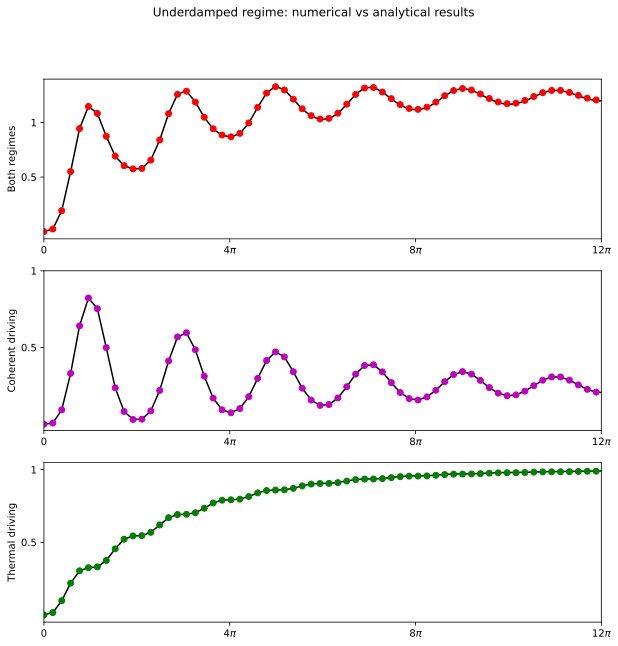

In [124]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle("Underdamped regime: numerical vs analytical results")
fig.set_figheight(10)
fig.set_figwidth(10)

ax1.plot(gtlist, E_B_theory_both_underdamped, '-k', gtlist, E_B_numeric_both, 'or')
ax1.set_ylabel("Both regimes")
ax1.set_xlim(0, 12*np.pi)
ax1.set_xticks([0., 4*np.pi, 8*np.pi, 12*np.pi],
               labels=["$0$", r"$4\pi$", r"$8\pi$", r"$12\pi$"])
ax1.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

ax2.plot(gtlist, E_B_theory_only_F_underdamped, '-k', gtlist, E_B_numeric_only_F, 'om')
ax2.set_ylabel("Coherent driving")
ax2.set_xlim(0, 12*np.pi)
ax2.set_xticks([0., 4*np.pi, 8*np.pi, 12*np.pi],
               labels=["$0$", r"$4\pi$", r"$8\pi$", r"$12\pi$"])
ax2.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

ax3.plot(gtlist, E_B_theory_only_T_underdamped, '-k', gtlist, E_B_numeric_only_T, 'og')
ax3.set_ylabel("Thermal driving")
ax3.set_xlim(0, 12*np.pi)
ax3.set_xticks([0., 4*np.pi, 8*np.pi, 12*np.pi],
               labels=["$0$", r"$4\pi$", r"$8\pi$", r"$12\pi$"])
ax3.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

plt.show()

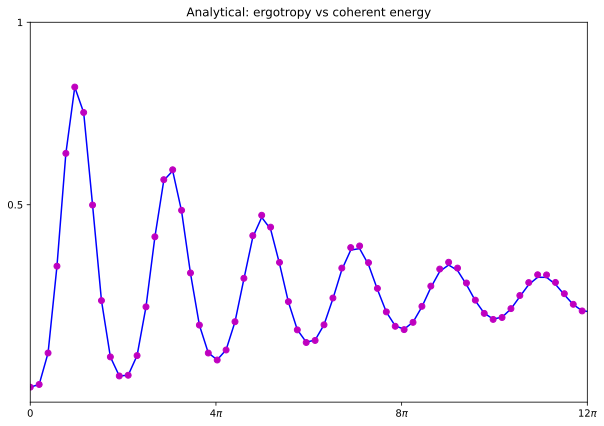

In [125]:
# check if analytical solutions for ergotropy and energy in T=0 case match
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, ergotropy_B_theory_both, '-b', gtlist, E_B_theory_only_F_underdamped, 'om')
ax.set_title("Analytical: ergotropy vs coherent energy")
ax.set_xlim(0, 12*np.pi)
ax.set_xticks([0., 4*np.pi, 8*np.pi, 12*np.pi],
               labels=["$0$", r"$4\pi$", r"$8\pi$", r"$12\pi$"])
ax.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])
plt.show()

In [126]:
# Overdamped case
F = 0.1 * w_zero
N_B = 1.0 # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F), rho0, gtlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_both_overdamped = [ expect(H_B, rho_B[i]) / w_zero for i in range(len(rho_B))]
ergotropy_B_both_overdamped = [ ergotropy(rho_B[i], H_B) / w_zero for i in range(len(rho_B)) ]
ergotropy_B_theory_both_overdamped = [ Ergotropy_B_theory(w_zero, rho_B[i]) / w_zero for i in range(len(rho_B)) ]

In [127]:
F = 0
N_B = 1.0 # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F), rho0, gtlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_only_T_overdamped = [ expect(H_B, rho_B[i]) / w_zero for i in range(len(rho_B))]
ergotropy_B_only_T_overdamped = [ ergotropy(rho_B[i], H_B) / w_zero for i in range(len(rho_B)) ]

In [128]:
F = 0.1 * w_zero
N_B = 0 # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F), rho0, gtlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_only_F_overdamped = [ expect(H_B, rho_B[i]) / w_zero for i in range(len(rho_B))]
ergotropy_B_only_F_overdamped = [ ergotropy(rho_B[i], H_B) / w_zero for i in range(len(rho_B)) ]

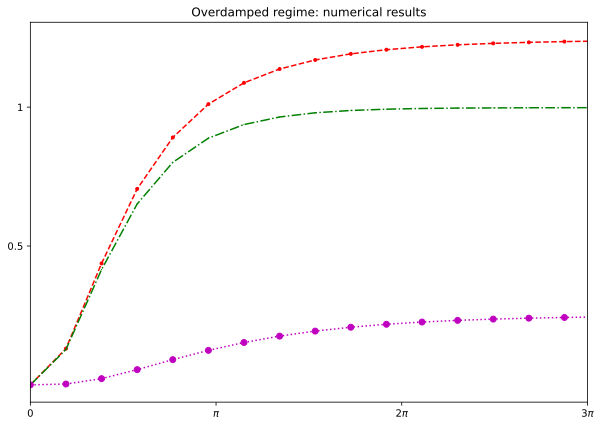

In [129]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, E_B_numeric_both_overdamped, '.--r', gtlist, E_B_numeric_only_T_overdamped, ',-.g', 
         gtlist, E_B_numeric_only_F_overdamped, 'o:m')
ax.set_title("Overdamped regime: numerical results")
ax.set_xlim(0, 3*np.pi)
ax.set_xticks([0., np.pi, 2*np.pi, 3*np.pi],
               labels=["$0$", r"$\pi$", r"$2\pi$", r"$3\pi$"])
ax.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

plt.show()

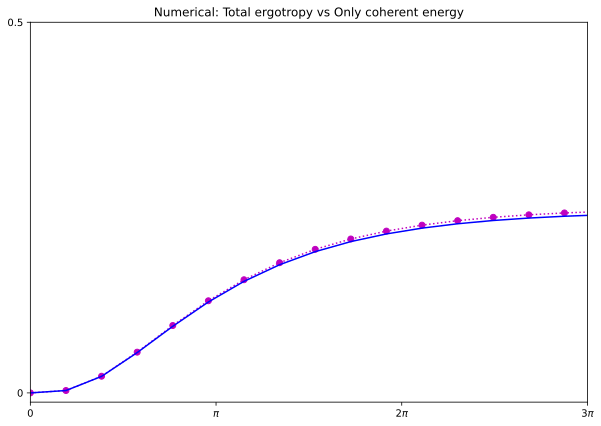

In [139]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, E_B_numeric_only_F_overdamped, 'o:m', gtlist, ergotropy_B_both_overdamped, '-b')
ax.set_title("Numerical: Total ergotropy vs Only coherent energy") #they should be superimposed!!
ax.set_xlim(0, 3*np.pi)
ax.set_xticks([0., np.pi, 2*np.pi, 3*np.pi],
               labels=["$0$", r"$\pi$", r"$2\pi$", r"$3\pi$"])
ax.set_yticks([0., 0.5], labels=["$0$", "$0.5$"])

plt.show()

In [131]:
F = 0.1 * w_zero
gamma = w_zero
N_B = 1.0

E_B_theory_only_F_overdamped = [ E_B_theory_only_F(w_zero,gamma,g,F,t) / w_zero for t in gtlist ]
E_B_theory_only_T_overdamped = [ E_B_theory_only_T(w_zero,gamma,g,N_B,t) / w_zero for t in gtlist ]
E_B_theory_both_overdamped = [ E_B_theory_only_F_overdamped[i] + E_B_theory_only_T_overdamped[i] 
                              for i in range(len(E_B_theory_only_F_overdamped))]

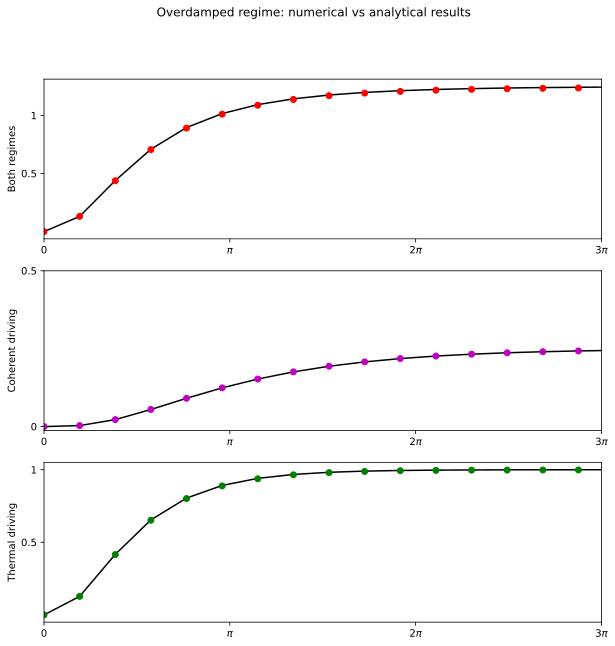

In [138]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle("Overdamped regime: numerical vs analytical results")
fig.set_figheight(10)
fig.set_figwidth(10)

ax1.plot(gtlist, E_B_theory_both_overdamped, '-k', gtlist, E_B_numeric_both_overdamped, 'or')
ax1.set_ylabel("Both regimes")
ax1.set_xlim(0, 3*np.pi)
ax1.set_xticks([0., np.pi, 2*np.pi, 3*np.pi],
               labels=["$0$", r"$\pi$", r"$2\pi$", r"$3\pi$"])
ax1.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

ax2.plot(gtlist, E_B_theory_only_F_overdamped, '-k', gtlist, E_B_numeric_only_F_overdamped, 'om')
ax2.set_ylabel("Coherent driving")
ax2.set_xlim(0, 3*np.pi)
ax2.set_xticks([0., np.pi, 2*np.pi, 3*np.pi],
               labels=["$0$", r"$\pi$", r"$2\pi$", r"$3\pi$"])
ax2.set_yticks([0., 0.5], labels=["$0$", "$0.5$"])

ax3.plot(gtlist, E_B_theory_only_T_overdamped, '-k', gtlist, E_B_numeric_only_T_overdamped, 'og')
ax3.set_ylabel("Thermal driving")
ax3.set_xlim(0, 3*np.pi)
ax3.set_xticks([0., np.pi, 2*np.pi, 3*np.pi],
               labels=["$0$", r"$\pi$", r"$2\pi$", r"$3\pi$"])
ax3.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

plt.show()

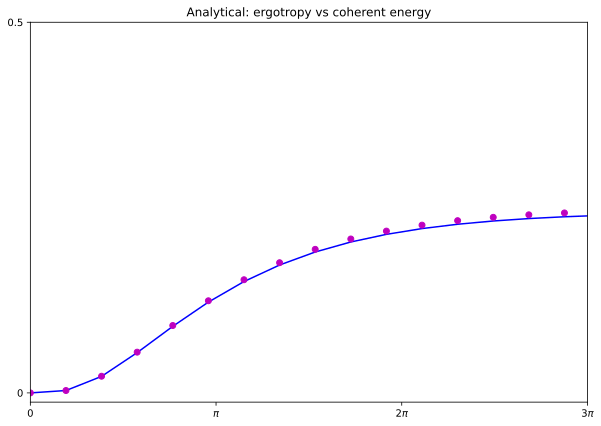

In [137]:
# check if analytical solutions for ergotropy and energy in T=0 case match
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, ergotropy_B_theory_both_overdamped, '-b', gtlist, E_B_theory_only_F_overdamped, 'om')
ax.set_title("Analytical: ergotropy vs coherent energy")
ax.set_xlim(0, 3*np.pi)
ax.set_xticks([0., np.pi, 2*np.pi, 3*np.pi],
               labels=["$0$", r"$\pi$", r"$2\pi$", r"$3\pi$"])
ax.set_yticks([0., 0.5], labels=["$0$", "$0.5$"])

plt.show()

In [ ]:
# Two qubit case
w_zero = 1.5
g = 0.2 * w_zero
H_B = (w_zero/2) * (sigmaz() + 1)

In [ ]:
# Two qubit case
sigma_am = tensor(sigmam(), qeye(2))
sigma_bm = tensor(qeye(2), sigmam())

#H_A = w_zero * a.dag() * a
#H_B = w_zero * b.dag() * b

def delta_HA_t0(_F):
    return _F * ( sigma_am.dag() + sigma_am )

def H_AB(_g):
    return _g * (sigma_am * sigma_bm.dag() + sigma_am.dag() * sigma_bm)

def D_A(_N_B, _gamma):
    return _gamma * (_N_B + 1) * lindblad_dissipator(sigma_am)

def D_AD(_N_B, _gamma):
    return _gamma * _N_B * lindblad_dissipator(sigma_am.dag())

# at t = 0, A and B do not interact, and they are respectvaly in their ground state
rho0 = tensor(fock_dm(2,1), fock_dm(2,1))

# times to resolve the m.e. at
gtlist = np.linspace(0, g*150, 250)

In [ ]:
#Underdamped case
F = 0.05 * w_zero
N_B = 0. # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = 0.05 * w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F/w_zero), rho0, gtlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_F_005 = [ expect(H_B, rho_B[i]) / w_zero for i in range(len(rho_B))]
ergotropy_B_F_005 = [ ergotropy(rho_B[i], H_B) / w_zero for i in range(len(rho_B)) ]

In [ ]:
F = 0.2 * w_zero
N_B = 0. # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = 0.05 * w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F/w_zero), rho0, gtlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_F_02 = [ expect(H_B, rho_B[i]) / w_zero for i in range(len(rho_B))]
ergotropy_B_F_02 = [ ergotropy(rho_B[i], H_B) / w_zero for i in range(len(rho_B)) ]

In [ ]:
F = w_zero
N_B = 0. # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = 0.05 * w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F/w_zero), rho0, gtlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_F_1 = [ expect(H_B, rho_B[i]) / w_zero for i in range(len(rho_B))]
ergotropy_B_F_1 = [ ergotropy(rho_B[i], H_B) / w_zero for i in range(len(rho_B)) ]

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, E_B_numeric_F_005, '--b', gtlist, E_B_numeric_F_02, '-r', gtlist, E_B_numeric_F_1, '-.k')
ax.set_title("Underdamped regime: E_B")
#ax.set_xlim(0, 4*np.pi)
#ax.set_xticks([0., 2*np.pi, 4*np.pi],
#               labels=["$0$", r"$2\pi$", r"$4\pi$"])
ax.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

plt.show()

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, ergotropy_B_F_005, '--b', gtlist, ergotropy_B_F_02, '-r', gtlist, ergotropy_B_F_1, '-.k')
ax.set_title("Underdamped regime: Ergotropy_B")
#ax.set_xlim(0, 4*np.pi)
#ax.set_xticks([0., 2*np.pi, 4*np.pi],
#               labels=["$0$", r"$2\pi$", r"$4\pi$"])
ax.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

plt.show()

In [ ]:
# Overdamped case
F = 0.05 * w_zero
N_B = 0. # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F/w_zero), rho0, gtlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_F_005_over = [ expect(H_B, rho_B[i]) / w_zero for i in range(len(rho_B))]
ergotropy_B_F_005_over = [ ergotropy(rho_B[i], H_B) / w_zero for i in range(len(rho_B)) ]

In [ ]:
F = 0.2 * w_zero
N_B = 0. # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = 0.05 * w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F/w_zero), rho0, gtlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_F_02_over = [ expect(H_B, rho_B[i]) / w_zero for i in range(len(rho_B))]
ergotropy_B_F_02_over = [ ergotropy(rho_B[i], H_B) / w_zero for i in range(len(rho_B)) ]

In [ ]:
F = w_zero
N_B = 0. # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = 0.05 * w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F/w_zero), rho0, gtlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_F_1_over = [ expect(H_B, rho_B[i]) / w_zero for i in range(len(rho_B))]
ergotropy_B_F_1_over = [ ergotropy(rho_B[i], H_B) / w_zero for i in range(len(rho_B)) ]

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, E_B_numeric_F_005_over, '--b', gtlist, E_B_numeric_F_02_over, '-r', gtlist, E_B_numeric_F_1_over, '-.k')
ax.set_title("Overdamped regime: E_B")
#ax.set_xlim(0, 4*np.pi)
#ax.set_xticks([0., 2*np.pi, 4*np.pi],
#               labels=["$0$", r"$2\pi$", r"$4\pi$"])
ax.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

plt.show()

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, ergotropy_B_F_005_over, '--b', gtlist, ergotropy_B_F_02_over, '-r', gtlist, ergotropy_B_F_1_over, '-.k')
ax.set_title("Overdamped regime: Ergotropy_B")
#ax.set_xlim(0, 4*np.pi)
#ax.set_xticks([0., 2*np.pi, 4*np.pi],
#               labels=["$0$", r"$2\pi$", r"$4\pi$"])
ax.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

plt.show()